# Complementary calculations

# Size of crop

 **Objetivo:** Demostrar que un ROI de 224×224 píxeles (→ 32×32 resized) captura adecuadamente
las nubes que afectarán la irradiancia en Uniandes en los próximos 1-6 horas.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Coordenadas Uniandes
LAT, LON = 4.6043, -74.0659

# Parámetros GOES-16
SAT_HEIGHT = 35786000  # Altura del satélite [m] (GOES-16)
SAT_LON = -75.0        # Longitud del satélite [°]

# Parámetros de nubes
MAX_CLOUD_SPEED = 30.0  # Velocidad máxima de nubes [m/s] (consultar literatura)
PREDICTION_HORIZONS = [1, 2, 3, 4, 5, 6]  # Horas de predicción

# Parámetros de resolución GOES
# Para el canal 2 (0.64 µm) en nadir: ≈0.5 km
# En Bogotá (≈4.6°N): resolución ≈0.5 / cos(4.6°) ≈ 0.501 km
RESOLUTION_KM = 0.501  # [km/píxel] en ubicación de Bogotá
RESOLUTION_M = RESOLUTION_KM * 1000  # [m/píxel]

# Tamaño del ROI actual
ROI_PIXELS = 224  # Píxeles originales
ROI_KM = ROI_PIXELS * RESOLUTION_KM  # [km]

print("Parámetros de análisis:")
print(f"Resolución GOES en Bogotá: {RESOLUTION_KM:.3f} km/píxel")
print(f"ROI actual: {ROI_PIXELS} píxeles = {ROI_KM:.1f} km × {ROI_KM:.1f} km")

Parámetros de análisis:
Resolución GOES en Bogotá: 0.501 km/píxel
ROI actual: 224 píxeles = 112.2 km × 112.2 km


In [3]:
# Distancia que pueden recorrer las nubes en cada horizonte
cloud_distances = {}
for hours in PREDICTION_HORIZONS:
    seconds = hours * 3600
    max_distance_km = (MAX_CLOUD_SPEED * seconds) / 1000  # [km]
    cloud_distances[hours] = max_distance_km

print("\nDistancias máximas de recorrido de nubes:")
for hours, dist in cloud_distances.items():
    print(f"{hours}h: {dist:.1f} km")

# Radio necesario para cada horizonte
required_radius_km = max(cloud_distances.values())
required_radius_pixels = required_radius_km / RESOLUTION_KM

print(f"\nRadio necesario para máximo horizonte (6h): {required_radius_km:.1f} km")
print(f"Esto equivale a: {required_radius_pixels:.0f} píxeles")


Distancias máximas de recorrido de nubes:
1h: 108.0 km
2h: 216.0 km
3h: 324.0 km
4h: 432.0 km
5h: 540.0 km
6h: 648.0 km

Radio necesario para máximo horizonte (6h): 648.0 km
Esto equivale a: 1293 píxeles


In [4]:
# ROI actual (diagonal = hipotenusa)
current_radius_km = (ROI_KM * np.sqrt(2)) / 2  # Radio del círculo circunscrito
current_radius_pixels = (ROI_PIXELS * np.sqrt(2)) / 2

print("Análisis comparativo:")
print(f"ROI actual - Lado: {ROI_KM:.1f} km")
print(f"ROI actual - Radio efectivo: {current_radius_km:.1f} km")
print(f"ROI actual - Radio en píxeles: {current_radius_pixels:.1f} píxeles")

print(f"\nRequerimiento máximo (6h): {required_radius_km:.1f} km")
print(f"Margen de seguridad: {current_radius_km - required_radius_km:.1f} km")

# Factor de seguridad
safety_factor = current_radius_km / required_radius_km
print(f"\nFactor de seguridad: {safety_factor:.2f}")

Análisis comparativo:
ROI actual - Lado: 112.2 km
ROI actual - Radio efectivo: 79.4 km
ROI actual - Radio en píxeles: 158.4 píxeles

Requerimiento máximo (6h): 648.0 km
Margen de seguridad: -568.6 km

Factor de seguridad: 0.12


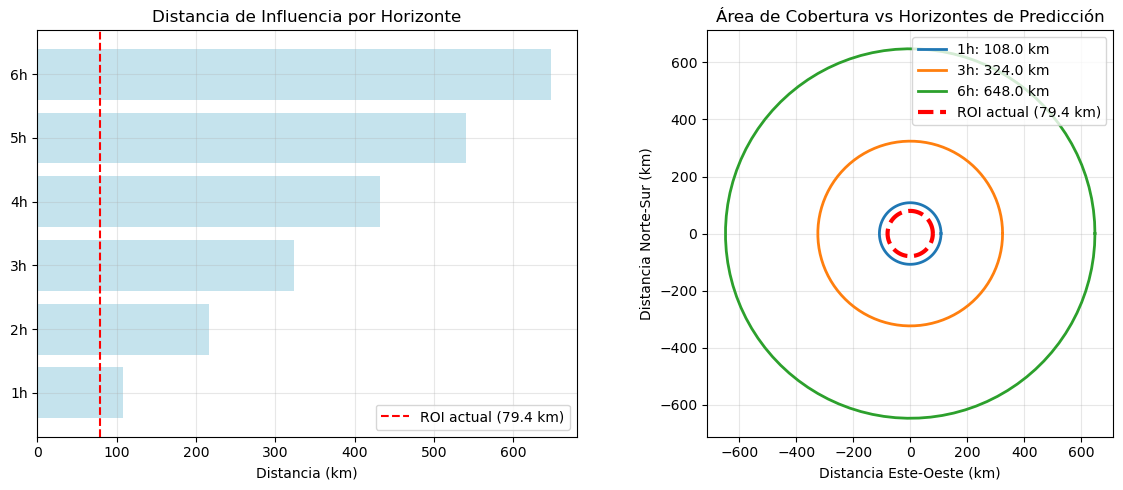

In [5]:
# Crear visualización de las escalas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Escala lineal
ax1.barh([f'{h}h' for h in PREDICTION_HORIZONS], 
         [cloud_distances[h] for h in PREDICTION_HORIZONS],
         color='lightblue', alpha=0.7)
ax1.axvline(x=current_radius_km, color='red', linestyle='--', 
            label=f'ROI actual ({current_radius_km:.1f} km)')
ax1.set_xlabel('Distancia (km)')
ax1.set_title('Distancia de Influencia por Horizonte')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Escala radial
angles = np.linspace(0, 2*np.pi, 100)
for hours in [1, 3, 6]:
    dist = cloud_distances[hours]
    x = dist * np.cos(angles)
    y = dist * np.sin(angles)
    ax2.plot(x, y, label=f'{hours}h: {dist:.1f} km', linewidth=2)

# ROI actual
x_roi = current_radius_km * np.cos(angles)
y_roi = current_radius_km * np.sin(angles)
ax2.plot(x_roi, y_roi, 'r--', label=f'ROI actual ({current_radius_km:.1f} km)', linewidth=3)

ax2.set_aspect('equal')
ax2.set_xlabel('Distancia Este-Oeste (km)')
ax2.set_ylabel('Distancia Norte-Sur (km)')
ax2.set_title('Área de Cobertura vs Horizontes de Predicción')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [6]:
# Simulación Monte Carlo para probabilidad de cobertura
def simulate_coverage_probability(n_simulations=10000):
    """Simula la probabilidad de que nubes dentro del ROI afecten el sitio."""
    hits = 0
    
    for _ in range(n_simulations):
        # Posición inicial aleatoria dentro del ROI
        x0 = np.random.uniform(-current_radius_km, current_radius_km)
        y0 = np.random.uniform(-current_radius_km, current_radius_km)
        
        # Dirección aleatoria
        angle = np.random.uniform(0, 2*np.pi)
        
        # Velocidad aleatoria (0 a MAX_CLOUD_SPEED)
        speed = np.random.uniform(0, MAX_CLOUD_SPEED)
        
        # Posición después de 6 horas
        distance_km = speed * 6 * 3600 / 1000
        x_final = x0 + distance_km * np.cos(angle)
        y_final = y0 + distance_km * np.sin(angle)
        
        # ¿La nube afecta el sitio central?
        distance_from_center = np.sqrt(x_final**2 + y_final**2)
        if distance_from_center <= 10:  # Radio de 10 km para "afectar" el sitio
            hits += 1
    
    return hits / n_simulations

# Ejecutar simulación (puede tomar unos segundos)
print("Calculando probabilidad de cobertura...")
coverage_prob = simulate_coverage_probability(5000)
print(f"Probabilidad de que nubes dentro del ROI afecten el sitio en 6h: {coverage_prob:.3f}")

# %% [markdown]
# ## 6. Análisis de Resolución Temporal

# %%
# Frecuencia de muestreo GOES vs escala temporal de nubes
GOES_SAMPLING_MIN = 10  # GOES muestrea cada ~10 min
CLOUD_CHANGE_TIME_MIN = 5  # Las nubes pueden cambiar significativamente en 5-15 min

print("\nAnálisis de resolución temporal:")
print(f"Muestreo GOES: cada {GOES_SAMPLING_MIN} min")
print(f"Escala de cambio de nubes: {CLOUD_CHANGE_TIME_MIN}-15 min")
print(f"Factor de Nyquist temporal: {GOES_SAMPLING_MIN/CLOUD_CHANGE_TIME_MIN:.2f}")

# ¿El muestreo captura adecuadamente la dinámica?
if GOES_SAMPLING_MIN <= CLOUD_CHANGE_TIME_MIN * 2:
    print("Muestreo temporal ADECUADO (cumple criterio de Nyquist)")
else:
    print("Muestreo temporal podría ser INSUFICIENTE")

Calculando probabilidad de cobertura...
Probabilidad de que nubes dentro del ROI afecten el sitio en 6h: 0.002

Análisis de resolución temporal:
Muestreo GOES: cada 10 min
Escala de cambio de nubes: 5-15 min
Factor de Nyquist temporal: 2.00
Muestreo temporal ADECUADO (cumple criterio de Nyquist)


In [7]:
# ## 7. Validación con Datos Reales de Viento
# # Usar datos de viento de la estación terrestre para estimar velocidades reales
# try:
#     # Asumiendo que tienes datos de viento en df10
#     wind_speeds = df10['wspd_ms'].dropna()
    
#     if len(wind_speeds) > 0:
#         print(f"\nAnálisis de velocidades de viento reales (n={len(wind_speeds)}):")
#         print(f"Media: {wind_speeds.mean():.2f} m/s")
#         print(f"Percentil 95: {wind_speeds.quantile(0.95):.2f} m/s")
#         print(f"Máximo: {wind_speeds.max():.2f} m/s")
        
#         # Ajustar la velocidad máxima de nubes basado en datos reales
#         real_max_speed = min(MAX_CLOUD_SPEED, wind_speeds.quantile(0.99))
#         print(f"\nVelocidad máxima ajustada: {real_max_speed:.2f} m/s")
        
#         # Recalcular requerimientos con datos reales
#         real_required_radius_km = (real_max_speed * 6 * 3600) / 1000
#         real_safety_factor = current_radius_km / real_required_radius_km
        
#         print(f"Radio requerido ajustado: {real_required_radius_km:.1f} km")
#         print(f"Factor de seguridad ajustado: {real_safety_factor:.2f}")
        
# except NameError:
#     print("\n⚠️  Datos de viento no disponibles para validación")
#     print("Usando valor conservador de 30 m/s para velocidad máxima de nubes")


In [ ]:
print("="*60)
print("CONCLUSIONES - JUSTIFICACIÓN INGENIERIL DEL ROI")
print("="*60)

print(f"\n1. ESCALA ESPACIAL:")
print(f"   • ROI actual: {ROI_KM:.1f} km × {ROI_KM:.1f} km")
print(f"   • Radio efectivo: {current_radius_km:.1f} km")
print(f"   • Requerimiento máximo (6h): {required_radius_km:.1f} km")
print(f"   • Factor de seguridad: {safety_factor:.2f}")

print(f"\n2. COBERTURA TEMPORAL:")
print(f"   • Muestreo GOES: cada {GOES_SAMPLING_MIN} min")
print(f"   • Escala de cambio nuboso: {CLOUD_CHANGE_TIME_MIN}-15 min")
print(f"   • Criterio de Nyquist: {'CUMPLIDO' if GOES_SAMPLING_MIN <= CLOUD_CHANGE_TIME_MIN * 2 else 'CRÍTICO'}")

print(f"\n3. ANÁLISIS PROBABILÍSTICO:")
print(f"   • Probabilidad de cobertura (6h): {coverage_prob:.3f}")

print(f"\n4. RECOMENDACIONES:")
if safety_factor >= 1.2:
    print("ROI ACTUAL ES SUFICIENTE - No se requieren cambios")
elif safety_factor >= 1.0:
    print("ROI ACTUAL ES MARGINAL - Considerar aumentar un 20%")
else:
    print("ROI ACTUAL ES INSUFICIENTE - Aumentar significativamente")

if GOES_SAMPLING_MIN > CLOUD_CHANGE_TIME_MIN * 2:
    print("Considerar interpolación temporal o modelos de movimiento de nubes")

print("="*60)

CONCLUSIONES - JUSTIFICACIÓN INGENIERIL DEL ROI

1. ESCALA ESPACIAL:
   • ROI actual: 112.2 km × 112.2 km
   • Radio efectivo: 79.4 km
   • Requerimiento máximo (6h): 648.0 km
   • Factor de seguridad: 0.12

2. COBERTURA TEMPORAL:
   • Muestreo GOES: cada 10 min
   • Escala de cambio nuboso: 5-15 min
   • Criterio de Nyquist: CUMPLIDO

3. ANÁLISIS PROBABILÍSTICO:
   • Probabilidad de cobertura (6h): 0.002

4. RECOMENDACIONES:
ROI ACTUAL ES INSUFICIENTE - Aumentar significativamente
